In [98]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
from sonnia.processing import Processing
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Reshape, Activation
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Concatenate
from sklearn.decomposition import PCA

In [99]:
from keras import backend as K
import keras
from keras import losses
from tensorflow.python.framework.ops import disable_eager_execution
from vampire_custom_keras import BetaWarmup, EmbedViaMatrix

disable_eager_execution()

In [100]:
def build(params):

    beta = K.variable(params['beta'])

    def sampling(args):
        """
        This function draws a sample from the multivariate normal defined by
        the latent variables.
        """
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(params['batch_size'], params['latent_dim']), mean=0.0, stddev=1.0)
        print(epsilon.shape)
        # Reparameterization trick!
        return (z_mean + K.exp(z_log_var / 2) * epsilon)

    def vae_cdr3_loss(io_encoder, io_decoder):
        """
        The loss function is the sum of the cross-entropy and KL divergence. KL
        gets a weight of beta.
        """
        # Here we multiply by the number of sites, so that we have a
        # total loss across the sites rather than a mean loss.
        xent_loss = params['max_cdr3_len'] * K.mean(losses.categorical_crossentropy(io_encoder, io_decoder))
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        kl_loss *= beta
        return (xent_loss + kl_loss)

    # Input:
    cdr3_input_shape = (params['max_cdr3_len'], params['n_aas'])
    cdr3_input = Input(shape=cdr3_input_shape, name='cdr3_input')
    v_gene_input = Input(shape=(params['n_v_genes'], ), name='v_gene_input')
    j_gene_input = Input(shape=(params['n_j_genes'], ), name='j_gene_input')

    # Encoding layers:
    cdr3_embedding = EmbedViaMatrix(params['aa_embedding_dim'], name='cdr3_embedding')(cdr3_input)
    cdr3_embedding_flat = Reshape([params['aa_embedding_dim'] * params['max_cdr3_len']],
                                  name='cdr3_embedding_flat')(cdr3_embedding)
    v_gene_embedding = Dense(params['v_gene_embedding_dim'], name='v_gene_embedding')(v_gene_input)
    j_gene_embedding = Dense(params['j_gene_embedding_dim'], name='j_gene_embedding')(j_gene_input)
    merged_embedding = keras.layers.concatenate([cdr3_embedding_flat, v_gene_embedding, j_gene_embedding],
                                                name='merged_embedding')
    encoder_dense_1 = Dense(params['dense_nodes'], activation='elu', name='encoder_dense_1')(merged_embedding)
    encoder_dense_2 = Dense(params['dense_nodes'], activation='elu', name='encoder_dense_2')(encoder_dense_1)

    # Latent layers:
    z_mean = Dense(params['latent_dim'], name='z_mean')(encoder_dense_2)
    z_log_var = Dense(params['latent_dim'], name='z_log_var')(encoder_dense_2)

    # Decoding layers:
    z_l = Lambda(sampling, output_shape=(params['latent_dim'], ), name='z')
    decoder_dense_1_l = Dense(params['dense_nodes'], activation='elu', name='decoder_dense_1')
    decoder_dense_2_l = Dense(params['dense_nodes'], activation='elu', name='decoder_dense_2')
    cdr3_post_dense_flat_l = Dense(np.array(cdr3_input_shape).prod(), activation='linear', name='cdr3_post_dense_flat')
    cdr3_post_dense_reshape_l = Reshape(cdr3_input_shape, name='cdr3_post_dense')
    cdr3_output_l = Activation(activation='softmax', name='cdr3_output')
    v_gene_output_l = Dense(params['n_v_genes'], activation='softmax', name='v_gene_output')
    j_gene_output_l = Dense(params['n_j_genes'], activation='softmax', name='j_gene_output')

    post_decoder = decoder_dense_2_l(decoder_dense_1_l(z_l([z_mean, z_log_var])))
    cdr3_output = cdr3_output_l(cdr3_post_dense_reshape_l(cdr3_post_dense_flat_l(post_decoder)))
    v_gene_output = v_gene_output_l(post_decoder)
    j_gene_output = j_gene_output_l(post_decoder)

    # Define the decoder components separately so we can have it as its own model.
    z_mean_input = Input(shape=(params['latent_dim'], ))
    decoder_post_decoder = decoder_dense_2_l(decoder_dense_1_l(z_mean_input))
    decoder_cdr3_output = cdr3_output_l(cdr3_post_dense_reshape_l(cdr3_post_dense_flat_l(decoder_post_decoder)))
    decoder_v_gene_output = v_gene_output_l(decoder_post_decoder)
    decoder_j_gene_output = j_gene_output_l(decoder_post_decoder)

    encoder = Model([cdr3_input, v_gene_input, j_gene_input], [z_mean, z_log_var])
    decoder = Model(z_mean_input, [decoder_cdr3_output, decoder_v_gene_output, decoder_j_gene_output])
    vae = Model([cdr3_input, v_gene_input, j_gene_input], [cdr3_output, v_gene_output, j_gene_output])
    vae.compile(
        optimizer="adam",
        loss={
            'cdr3_output': vae_cdr3_loss,
            'v_gene_output': keras.losses.categorical_crossentropy,
            'j_gene_output': keras.losses.categorical_crossentropy,
        },
        loss_weights={
            # Keep the cdr3_output weight to be 1. The weights are relative
            # anyhow, and buried inside the vae_cdr3_loss is a beta weight that
            # determines how much weight the KL loss has. If we keep this
            # weight as 1 then we can interpret beta in a straightforward way.
            "cdr3_output": 1,
            "j_gene_output": 0.1305,
            "v_gene_output": 0.8138
        })

    callbacks = [BetaWarmup(beta, params['beta'], params['warmup_period'])]

    return {'encoder': encoder, 'decoder': decoder, 'vae': vae, 'callbacks': callbacks}

In [101]:
df = pd.read_csv('peptide-detail-ci_filtered_aligned_merged.csv')
df["Amino Acids 1"] = df["Amino Acids"].apply(lambda x: x.split(",")[0])
df

,CDR3,CDR3_al,tokenized_smiles,TCR BioIdentity,TCR Nucleotide Sequence,Experiment,ORF Coverage,Amino Acids,Start Index in Genome,End Index in Genome,v_gene,j_gene,Amino Acids 1
0,CASSAQGTGDRGYTF,CASSA-----QGTGDRGYTF,"[12, 16, 34, 34, 31, 31, 31, 31, 31, 27, 13]",CASSAQGTGDRGYTF+TCRBV27-01+TCRBJ01-02,GAGTCGCCCAGCCCCAACCAGACCTCTCTGTACTTCTGTGCCAGCA...,eAV93,"ORF1ab,surface glycoprotein","ADAGFIKQY,AELEGIQY,LADAGFIKQY,TLADAGFIK",533,24073,TCRBV27-01,TCRBJ01-02,ADAGFIKQY
1,CASSLVATGNTGELFF,CASSL----VATGNTGELFF,"[12, 16, 34, 34, 31, 31, 31, 31, 23, 27, 27, 13]",CASSLVATGNTGELFF+TCRBV07-09+TCRBJ02-02,CGCACAGAGCAGGGGGACTCGGCCATGTATCTCTGTGCCAGCAGCT...,eOX56,"ORF1ab,surface glycoprotein","ADAGFIKQY,AELEGIQY,LADAGFIKQY,TLADAGFIK",533,24073,TCRBV07-09,TCRBJ02-02,ADAGFIKQY
2,CALKVGADTQYF,CALKV--------GADTQYF,"[12, 16, 31, 31, 31, 31, 31, 31, 31, 31, 27, 13]",CALKVGADTQYF+TCRBV30-01+TCRBJ02-03,CTGAGTTCTAAGAAGCTCCTTCTCAGTGACTCTGGCTTCTATCTCT...,eQD124,"ORF1ab,surface glycoprotein","ADAGFIKQY,AELEGIQY,LADAGFIKQY,TLADAGFIK",533,24073,TCRBV30-01,TCRBJ02-03,ADAGFIKQY
3,CASSLWASGRGGTGELFF,CASSLW--ASGRGGTGELFF,"[12, 16, 34, 34, 31, 31, 34, 27, 27, 13]",CASSLWASGRGGTGELFF+TCRBV27-01+TCRBJ02-02,AGCCCCAACCAGACCTCTCTGTACTTCTGTGCCAGCAGTTTATGGG...,eAV93,"ORF1ab,surface glycoprotein","ADAGFIKQY,AELEGIQY,LADAGFIKQY,TLADAGFIK",533,24073,TCRBV27-01,TCRBJ02-02,ADAGFIKQY
4,CASSLLGWEQLDEQFF,CASSL----LGWEQLDEQFF,"[12, 16, 34, 34, 31, 31, 31, 31, 27, 27, 13]",CASSLLGWEQLDEQFF+TCRBV27-01+TCRBJ02-01,TCGCCCAGCCCCAACCAGACCTCTCTGTACTTCTGTGCCAGCAGTT...,eMR16,"ORF1ab,surface glycoprotein","ADAGFIKQY,AELEGIQY,LADAGFIKQY,TLADAGFIK",533,24073,TCRBV27-01,TCRBJ02-01,ADAGFIKQY
...,...,...,...,...,...,...,...,...,...,...,...,...,...
236340,CASSSGPQETQYF,CASSS-------GPQETQYF,"[12, 16, 34, 34, 34, 31, 31, 31, 31, 31, 31, 3...",CASSSGPQETQYF+TCRBV07-09+TCRBJ02-05,GAGATCCAGCGCACAGAGCAGGGGGACTCGGCCATGTATCTCTGTG...,eAV88,ORF10,"AQVDVVNFNL,NYIAQVDVV",29630,29668,TCRBV07-09,TCRBJ02-05,AQVDVVNFNL
236341,CASSKRDSQETQYF,CASSK------RDSQETQYF,"[12, 16, 34, 34, 31, 31, 31, 31, 31, 31, 34, 2...",CASSKRDSQETQYF+TCRBV07-09+TCRBJ02-05,ATCCAGCGCACAGAGCAGGGGGACTCGGCCATGTATCTCTGTGCCA...,eDH105,ORF10,"AQVDVVNFNL,NYIAQVDVV",29630,29668,TCRBV07-09,TCRBJ02-05,AQVDVVNFNL
236342,CASSQLPGQGKVQYF,CASSQ-----LPGQGKVQYF,"[12, 16, 34, 34, 31, 31, 31, 31, 31, 45, 27, 13]",CASSQLPGQGKVQYF+TCRBV04-01+TCRBJ02-07,CACGCCCTGCAGCCAGAAGACTCAGCCCTGTATCTCTGCGCCAGCA...,eAV93,ORF10,"AQVDVVNFNL,NYIAQVDVV",29630,29668,TCRBV04-01,TCRBJ02-07,AQVDVVNFNL
236343,CASSPGDNEQFF,CASSP--------GDNEQFF,"[12, 16, 34, 34, 45, 31, 31, 31, 31, 31, 31, 3...",CASSPGDNEQFF+TCRBV09-01+TCRBJ02-01,CTAAACCTGAGCTCTCTGGAGCTGGGGGACTCAGCTTTGTATTTCT...,eEE224,ORF10,"AQVDVVNFNL,NYIAQVDVV",29630,29668,TCRBV09-01,TCRBJ02-01,AQVDVVNFNL


In [102]:
df = pd.read_csv('metaclonotypes_tcrdist_3groups.csv')
df

,CDR3,CDR3_al,tokenized_smiles,TCR BioIdentity,TCR Nucleotide Sequence,Experiment,ORF Coverage,Amino Acids,Start Index in Genome,End Index in Genome,v_gene,j_gene,Amino Acids 1,CDR3_al_one_hot,CDR3_al_integer,label,file
0,CASSRKTDSYEQYF,CASSR------KTDSYEQYF,"[12, 16, 34, 34, 31, 31, 31, 31, 31, 31, 34, 2...",CASSRKTDSYEQYF+TCRBV28-01+TCRBJ02-07,CTGGAGTCCGCCAGCACCAACCAGACATCTATGTACCTCTGTGCCA...,eQD110,ORF1ab,"ALRKVPTDNYITTY,KVPTDNYITTY",4211,4252,TCRBV28-01,TCRBJ02-07,ALRKVPTDNYITTY,[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0....,[ 2 1 16 16 15 0 0 0 0 0 0 9 17 3 16 ...,20,0
1,CASSRKTDSYEQYF,CASSR------KTDSYEQYF,"[12, 16, 34, 34, 31, 31, 31, 31, 31, 31, 34, 2...",CASSRKTDSYEQYF+TCRBV28-01+TCRBJ02-07,CTGGAGTCCGCCAGCACCAACCAGACATCTATGTACCTCTGTGCCA...,eQD126,ORF1ab,"ALRKVPTDNYITTY,KVPTDNYITTY",4211,4252,TCRBV28-01,TCRBJ02-07,ALRKVPTDNYITTY,[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0....,[ 2 1 16 16 15 0 0 0 0 0 0 9 17 3 16 ...,20,0
2,CASSRKTDSYEQYF,CASSR------KTDSYEQYF,"[12, 16, 34, 34, 31, 31, 31, 31, 31, 31, 34, 2...",CASSRKTDSYEQYF+TCRBV28-01+TCRBJ02-07,CTGGAGTCCGCCAGCACCAACCAGACATCTATGTACCTCTGTGCCA...,eQD110,ORF1ab,"ALRKVPTDNYITTY,KVPTDNYITTY",4211,4252,TCRBV28-01,TCRBJ02-07,ALRKVPTDNYITTY,[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0....,[ 2 1 16 16 15 0 0 0 0 0 0 9 17 3 16 ...,20,0
3,CASSRKTDSYEQYF,CASSR------KTDSYEQYF,"[12, 16, 34, 34, 31, 31, 31, 31, 31, 31, 34, 2...",CASSRKTDSYEQYF+TCRBV28-01+TCRBJ02-07,CTGGAGTCCGCCAGCACCAACCAGACATCTATGTACCTCTGTGCCA...,eQD126,ORF1ab,"ALRKVPTDNYITTY,KVPTDNYITTY",4211,4252,TCRBV28-01,TCRBJ02-07,ALRKVPTDNYITTY,[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0....,[ 2 1 16 16 15 0 0 0 0 0 0 9 17 3 16 ...,20,0
4,CASSLRTDSYEQYF,CASSL------RTDSYEQYF,"[12, 16, 34, 34, 31, 31, 31, 31, 31, 31, 34, 2...",CASSLRTDSYEQYF+TCRBV28-01+TCRBJ02-07,CTGGAGTCCGCCAGCACCAACCAGACATCTATGTACCTCTGTGCCA...,eQD110,ORF1ab,"ALRKVPTDNYITTY,KVPTDNYITTY",4211,4252,TCRBV28-01,TCRBJ02-07,ALRKVPTDNYITTY,[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0....,[ 2 1 16 16 10 0 0 0 0 0 0 15 17 3 16 ...,20,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3498,CASSPGGSEQYF,CASSP--------GGSEQYF,"[12, 16, 34, 34, 45, 31, 31, 31, 31, 31, 31, 3...",CASSPGGSEQYF+TCRBV18-01+TCRBJ02-07,CTGAGGATCCAGCAGGTAGTGCGAGGAGATTCGGCAGCTTATTTCT...,eXL30,ORF1ab,"DTDFVNEFYAY,NRDVDTDFVNEFY",15641,15685,TCRBV18-01,TCRBJ02-07,DTDFVNEFYAY,[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0....,[ 2 1 16 16 13 0 0 0 0 0 0 0 0 6 6 ...,50,2
3499,CASSPGGTGYTF,CASSP--------GGTGYTF,"[12, 16, 34, 34, 45, 31, 31, 31, 31, 31, 31, 3...",CASSPGGTGYTF+TCRBV18-01+TCRBJ01-02,CTGAGGATCCAGCAGGTAGTGCGAGGAGATTCGGCAGCTTATTTCT...,eEE226,ORF1ab,"DTDFVNEFYAY,NRDVDTDFVNEFY",15641,15685,TCRBV18-01,TCRBJ01-02,DTDFVNEFYAY,[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0....,[ 2 1 16 16 13 0 0 0 0 0 0 0 0 6 6 ...,50,2
3500,CASSPGGQKLFF,CASSP--------GGQKLFF,"[12, 16, 34, 34, 45, 31, 31, 31, 31, 31, 31, 3...",CASSPGGQKLFF+TCRBV18-01+TCRBJ01-04,CTGAGGATCCAGCAGGTAGTGCGAGGAGATTCGGCAGCTTATTTCT...,eXL30,ORF1ab,"DTDFVNEFYAY,NRDVDTDFVNEFY",15641,15685,TCRBV18-01,TCRBJ01-04,DTDFVNEFYAY,[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0....,[ 2 1 16 16 13 0 0 0 0 0 0 0 0 6 6 ...,50,2
3501,CASSPGGTRLFF,CASSP--------GGTRLFF,"[12, 16, 34, 34, 45, 31, 31, 31, 31, 31, 31, 3...",CASSPGGTRLFF+TCRBV18-01+TCRBJ01-04,CTGAGGATCCAGCAGGTAGTGCGAGGAGATTCGGCAGCTTATTTCT...,eEE226,ORF1ab,"DTDFVNEFYAY,NRDVDTDFVNEFY",15641,15685,TCRBV18-01,TCRBJ01-04,DTDFVNEFYAY,[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0....,[ 2 1 16 16 13 0 0 0 0 0 0 0 0 6 6 ...,50,2


In [103]:
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

aa = ["A", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N", "P", "Q","R", "S", "T", "V", "W", "Y", "-"]

# integer encode
label_encoder = LabelEncoder()
y_encoder =LabelEncoder()
y_encoder = y_encoder.fit(df['Amino Acids'].unique())
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = label_encoder.fit_transform(aa)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit(integer_encoded)


/opt/anaconda3/envs/m4r/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [104]:
one_hot_status = True
col_one_hot = []
col_integer = []
y_labels = []
for k in tqdm(df.index):
    integer_encoded = label_encoder.transform(list(df.loc[k,"CDR3_al"]))
    col_integer.append(integer_encoded)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    if one_hot_status:
        onehot_encoded = onehot_encoder.transform(integer_encoded)
        col_one_hot.append(onehot_encoded)
    y_label = y_encoder.transform([df.loc[k,"Amino Acids"]])
    y_labels.append(y_label)
    

  0%|          | 0/3503 [00:00<?, ?it/s]

In [105]:
y_labels = [int(y) for y in y_labels]
if one_hot_status:
    df["CDR3_al_one_hot"] = col_one_hot
df["CDR3_al_integer"] = col_integer
df["label"] = y_labels

In [106]:
v_labels = []
v_encoder = LabelEncoder()
v_encoder_one_hot = OneHotEncoder(sparse=False)
v_encoder = v_encoder.fit(df['v_gene'].unique())
v_encoder_one_hot = v_encoder_one_hot.fit(v_encoder.transform(df['v_gene'].unique()).reshape(-1,1))
for k in tqdm(df.index):
    v_label = v_encoder.transform([df.loc[k,"v_gene"]])
    v_label = v_encoder_one_hot.transform(v_label.reshape(-1,1))
    v_labels.append(v_label)
df["v_gene_one_hot"] = v_labels

j_labels = []
j_encoder = LabelEncoder()
j_encoder_one_hot = OneHotEncoder(sparse=False)
j_encoder = j_encoder.fit(df['j_gene'].unique())
j_encoder_one_hot = j_encoder_one_hot.fit(j_encoder.transform(df['j_gene'].unique()).reshape(-1,1))
for k in tqdm(df.index):
    j_label = j_encoder.transform([df.loc[k,"j_gene"]])
    j_label = j_encoder_one_hot.transform(j_label.reshape(-1,1))
    j_labels.append(j_label)
df["j_gene_one_hot"] = j_labels

/opt/anaconda3/envs/m4r/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


  0%|          | 0/3503 [00:00<?, ?it/s]

/opt/anaconda3/envs/m4r/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


  0%|          | 0/3503 [00:00<?, ?it/s]

In [107]:
df["j_gene_one_hot"][0].shape

(1, 8)

In [108]:
df = df.sample(frac=1).reset_index(drop=True)
data = df[['CDR3_al_one_hot', 'v_gene_one_hot', 'j_gene_one_hot']]
data["v_gene_one_hot"]  = data["v_gene_one_hot"].apply(lambda x: x.reshape(6,))
data["j_gene_one_hot"]  = data["j_gene_one_hot"].apply(lambda x: x.reshape(8,))
data = [np.stack(col.values) for _, col in data.items()]
#X_train = tf.constant(df["CDR3"].to_numpy())
#X_train_v_gene = tf.constant(df["v_gene"].to_numpy())
#X_train_j_gene = tf.constant(df["j_gene"].to_numpy())
X_train = data

/var/folders/rl/d4jq2g217cv1hy_ssxxj4k0r0000gn/T/ipykernel_13145/2563631872.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["v_gene_one_hot"]  = data["v_gene_one_hot"].apply(lambda x: x.reshape(6,))
/var/folders/rl/d4jq2g217cv1hy_ssxxj4k0r0000gn/T/ipykernel_13145/2563631872.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["j_gene_one_hot"]  = data["j_gene_one_hot"].apply(lambda x: x.reshape(8,))


In [109]:
X_train

[array([[[0., 0., 1., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 1., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 1., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 1., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 1., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 1., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        ...,
 
        [[0., 0., 1., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 1.],


In [110]:
#keep only first 3500 
for i in range(len(X_train)):
    X_train[i] = X_train[i][:3500]

In [111]:
params = {
            "latent_dim": 35,
            "dense_nodes": 75,
            "aa_embedding_dim": 21,
            "v_gene_embedding_dim": 54,
            "j_gene_embedding_dim": 13,
            "beta": 0.75,
            "max_cdr3_len": 20,
            "n_aas": 21,
            "n_v_genes": 6,
            "n_j_genes": 8,
            "stopping_monitor": "val_loss",
            "batch_size": 5,
            "pretrains": 2,
            "warmup_period": 3,
            "epochs": 4,
            "patience": 20,
            "n_inputs" : 20,
            "v_inputs" : 54,
            "j_inputs" : 13
        }

In [112]:
res = build(params)

(5, 35)


In [113]:
res["vae"].fit(X_train, X_train, epochs=100, batch_size=5,verbose=1) 

Train on 3500 samples
Epoch 1/100
3500/3500 [==============================] - 1s 340us/sample - loss: 9.0062 - cdr3_output_loss: 8.5285 - v_gene_output_loss: 0.5190 - j_gene_output_loss: 0.4244
Epoch 2/100
3500/3500 [==============================] - 1s 274us/sample - loss: 4.0329 - cdr3_output_loss: 3.7960 - v_gene_output_loss: 0.2661 - j_gene_output_loss: 0.1561
Epoch 3/100
3500/3500 [==============================] - 1s 275us/sample - loss: 3.4477 - cdr3_output_loss: 3.2415 - v_gene_output_loss: 0.2368 - j_gene_output_loss: 0.1027
Epoch 4/100
3500/3500 [==============================] - 1s 275us/sample - loss: 3.2004 - cdr3_output_loss: 3.0176 - v_gene_output_loss: 0.2107 - j_gene_output_loss: 0.0865
Epoch 5/100
3500/3500 [==============================] - 1s 272us/sample - loss: 2.9479 - cdr3_output_loss: 2.7862 - v_gene_output_loss: 0.1861 - j_gene_output_loss: 0.0785
Epoch 6/100
3500/3500 [==============================] - 1s 271us/sample - loss: 2.9081 - cdr3_output_loss: 2.749

In [114]:
df["file"].unique()

array([1, 2, 0])

  0%|          | 0/3503 [00:00<?, ?it/s]

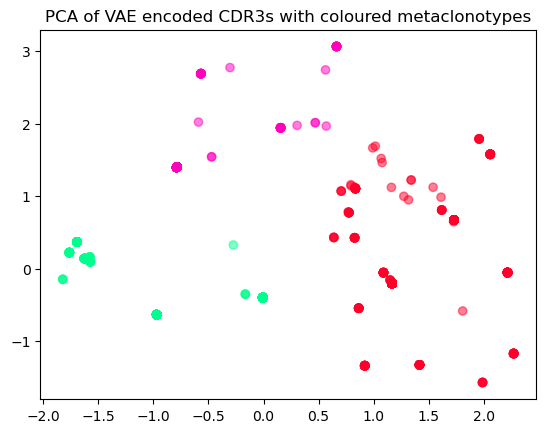

Accuracy:  0.999


/opt/anaconda3/envs/m4r/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/rl/d4jq2g217cv1hy_ssxxj4k0r0000gn/T/ipykernel_13145/734488935.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample[str(label+"_kmeans_label")] = kmeans.labels_


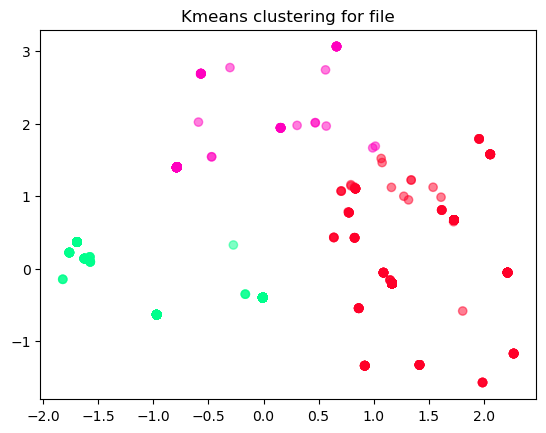

In [123]:
label = "file"
labels = []
labels_encoder = LabelEncoder()
labels_encoder = labels_encoder.fit(df[label].unique())
for k in tqdm(df.index):
    labels.append(labels_encoder.transform([df.loc[k,label]]))
labels = [int(y) for y in labels]
df[label] = labels
rgb_values = sns.color_palette("Spectral", df[label].nunique())
df[str(label+"_color")] = df[label].apply(lambda x: rgb_values[x])

N=2000
X_test = X_train.copy()
for i in range(len(X_test)):
    X_test[i] = X_test[i][:N]

X_test_encode = res["encoder"].predict(X_test)
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_test_encode[0])
plot_X_test = principalComponents # X_test_encode[0] not working well

plt.scatter(plot_X_test[:,0], plot_X_test[:,1], c=df[label][:N], cmap="gist_rainbow", alpha=0.5)
plt.title("PCA of VAE encoded CDR3s with coloured metaclonotypes")
plt.show()

k = 3
kmeans = KMeans(n_clusters=k, random_state=0).fit(X_test_encode[0][:N])
labels = pd.Series(kmeans.labels_)
rgb_values = sns.color_palette("Spectral", k)
col_kmeans = labels.apply(lambda x: rgb_values[x])
sample = df[:N]
sample[str(label+"_kmeans_label")] = kmeans.labels_
label_dict = {}
for cluster in range(k):
    label_ind = sample[sample[str(label+"_kmeans_label")] == cluster][label].value_counts().index[0]
    label_dict[cluster] = label_ind

print("Accuracy: ", sum([label_dict[x] == y for x,y in zip(sample[str(label+"_kmeans_label")], sample[label])])/len(sample))
plt.scatter(plot_X_test[:,0], plot_X_test[:,1], c=labels, cmap="gist_rainbow", alpha=0.5)
centroids = kmeans.cluster_centers_
plt.title("Kmeans clustering for "+label)
plt.show()

In [ ]:
Hello, 

I hope that you had a great week! 

It is just a quick message to let you know about some good results that I have found. It seems that the Autoencoder and the Variational Autoencoder are able to learn the structure of the CDR3 sequences in the same manner as the RBM. 
Here are below some screenshots of the results that I have obtained. It seems that both the Autoencoder and the Variational Autoencoder can cluster pretty well the different metaclonotypes.

I wish a very nice week-end! 
Yanis 